# Segmentación de usuarios con aprendizaje no supervisado
## 1) Introducción
- Implementamos un flujo de segmentación no supervisada con K-Means, DBSCAN, PCA y t-SNE sobre `citaschallenge`.
- Estructuramos el trabajo en etapas para conectar decisiones técnicas con interpretación de negocio.
- Priorizamos comparación entre métodos para evaluar separabilidad, estabilidad e interpretabilidad.
- Cerramos con perfiles y recomendaciones aplicables al contexto del problema.
**Evidencia:** `Results/segmentacion_kmeans_edad.png`, `Results/segmentacion_dbscan_edad.png`, `Results/comparativo_kmeans_dbscan.png`.


In [2]:
# Preparamos el entorno de trabajo para todo el flujo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

RANDOM_STATE = 42
RESULTS_DIR = Path('../Results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')


## 2) Comprensión del dataset
- Revisamos `head`, `info` y `describe` para validar volumen, tipos y cobertura de variables.
- Confirmamos que el dataset contiene señales demográficas y de negocio útiles para segmentación.
- Verificamos consistencia estructural antes de aplicar transformaciones.
- Delimitamos variables candidatas para clustering desde esta inspección inicial.
**Evidencia:** salida tabular de la celda de carga y estructura de columnas en `Notebooks/Grupo1_semana3.ipynb`.


In [3]:
df = pd.read_excel('../Dataset/citaschallenge.xlsx')

print(df.head())
print(df.info())
print(df.describe(include='all'))


     GENERO  EDAD         ESPECIALIDAD TIPO_AFILIACION          FECHA_CITA  \
0  FEMENINO  41.0           ORTODONCIA            GOLD 2013-07-02 06:30:00   
1  FEMENINO  49.0  TERAPIA OCUPACIONAL          SILVER 2013-07-02 06:30:00   
2  FEMENINO  41.0         FISIOTERAPIA            GOLD 2013-07-02 06:30:00   
3  FEMENINO  49.0         FISIOTERAPIA            GOLD 2013-07-02 06:50:00   
4  FEMENINO  36.0           RADIOLOGIA            GOLD 2013-07-02 06:50:00   

      id  ESTAFINAL  
0   9373          3  
1  62884          2  
2  72568          2  
3   5733          1  
4  22397          3  
<class 'pandas.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  str           
 1   EDAD             67650 non-null  float64       
 2   ESPECIALIDAD     67650 non-null  str           
 3   TIPO_AFILIACION  67650 non-null 

## 3) Limpieza y preprocesamiento
- Verificamos nulos y duplicados para asegurar calidad de datos antes del modelado.
- Transformamos variables categóricas con mapeos explícitos y validamos categorías inesperadas.
- Estandarizamos tipos (`int`) para evitar errores de ejecución y comportamiento inconsistente.
- Dejamos una matriz limpia y coherente para algoritmos basados en distancia.
**Evidencia:** celdas de control de nulos/duplicados y tablas exportadas `Results/resumen_clusters_kmeans.csv` / `Results/resumen_clusters_dbscan.csv`.


In [4]:
print('Valores nulos por columna:')
print(df.isnull().sum())

print()
print(f'Cantidad de filas duplicadas: {df.duplicated().sum()}')

# Definimos mapeos para transformar variables categoricas a numericas.
gender_map = {'FEMENINO': 0, 'MASCULINO': 1}
affiliation_map = {'CONVENIO': 1, 'SILVER': 2, 'GOLD': 3}

df['GENERO'] = df['GENERO'].str.upper().map(gender_map)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].str.upper().map(affiliation_map)

if df['GENERO'].isnull().any():
    faltantes = sorted(df.loc[df['GENERO'].isnull(), 'GENERO'].astype(str).unique())
    raise ValueError(f'Valores inesperados en GENERO tras mapeo: {faltantes}')

if df['TIPO_AFILIACION'].isnull().any():
    faltantes = sorted(df.loc[df['TIPO_AFILIACION'].isnull(), 'TIPO_AFILIACION'].astype(str).unique())
    raise ValueError(f'Valores inesperados en TIPO_AFILIACION tras mapeo: {faltantes}')

df['GENERO'] = df['GENERO'].astype(int)
df['EDAD'] = df['EDAD'].astype(int)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].astype(int)

print()
print('Tipos de datos luego de limpieza:')
print(df.dtypes)


Valores nulos por columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64

Cantidad de filas duplicadas: 0

Tipos de datos luego de limpieza:
GENERO                      int64
EDAD                        int64
ESPECIALIDAD                  str
TIPO_AFILIACION             int64
FECHA_CITA         datetime64[us]
id                          int64
ESTAFINAL                   int64
dtype: object


## 4) Visualizaciones iniciales
- Construimos `pairplot` para observar distribución y relaciones bivariadas entre variables del modelo.
- Calculamos matriz de correlación para detectar dependencia lineal y redundancia potencial.
- Contrastamos patrones visuales con hipótesis de segmentación previas al entrenamiento.
- Usamos estas señales para sostener la elección de variables y escalado.
**Evidencia:** `Results/visualizacion_distribuciones.png` y `Results/matriz_correlacion.png`.


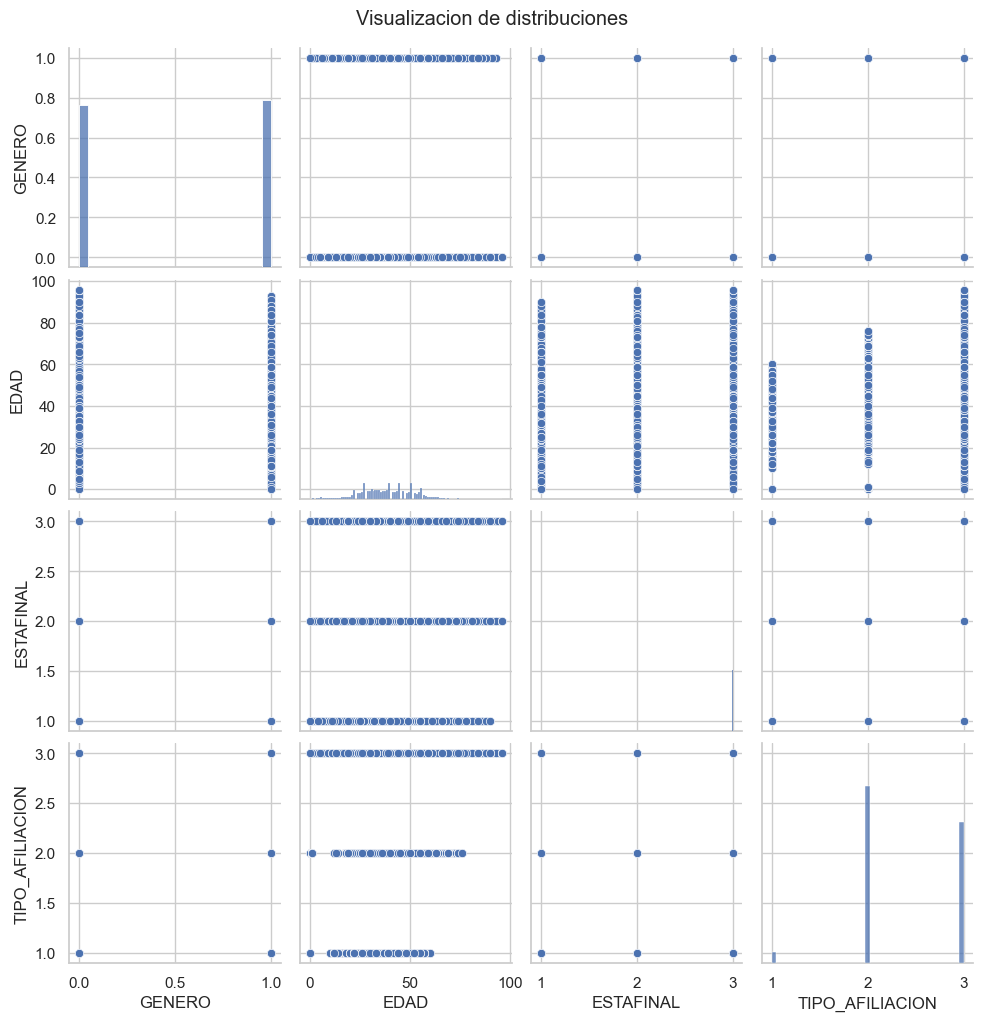

In [5]:
pairplot = sns.pairplot(df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']])
pairplot.fig.suptitle('Visualizacion de distribuciones', y=1.02)
pairplot.fig.savefig(RESULTS_DIR / 'visualizacion_distribuciones.png', dpi=150, bbox_inches='tight')
plt.show()


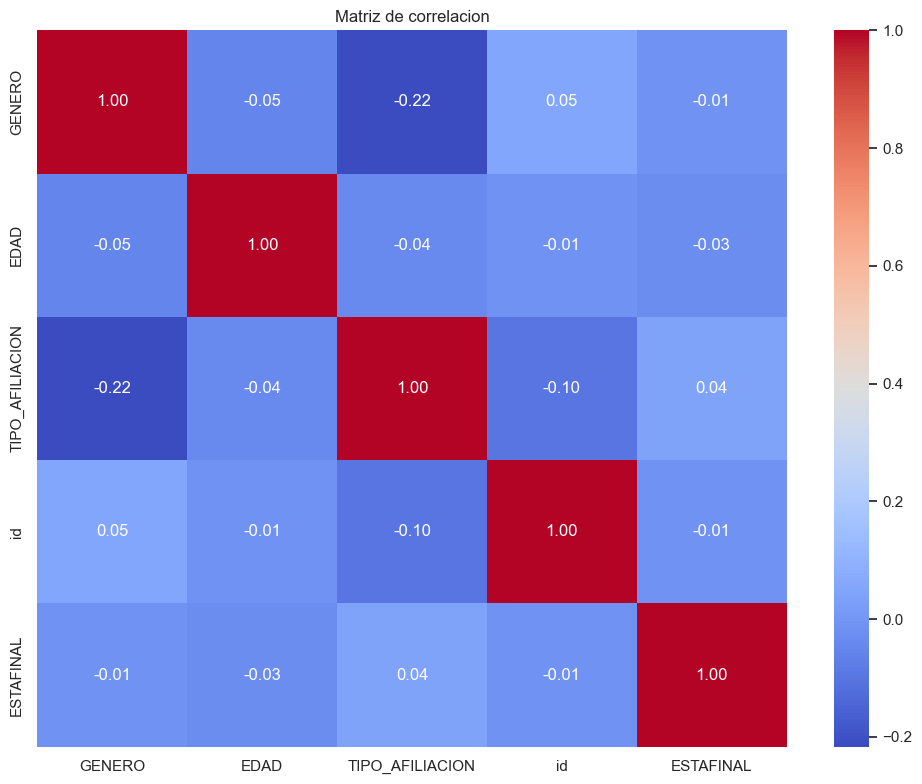

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'matriz_correlacion.png', dpi=150)
plt.show()


### Escalado previo al clustering
- Definimos el espacio de entrada con `GENERO`, `EDAD`, `ESTAFINAL` y `TIPO_AFILIACION`.
- Aplicamos `StandardScaler` para igualar peso relativo de variables en distancia euclidiana.
- Prevenimos que magnitudes distintas sesguen K-Means y DBSCAN.
**Evidencia:** celda de construcción de `X` y `X_scaled` en `Notebooks/Grupo1_semana3.ipynb`.


In [7]:
X = df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5) KMeans: selección de k + entrenamiento
- Estimamos el número de clusters con método del codo e índice silhouette.
- Entrenamos K-Means con el `k` seleccionado y evaluamos separación de segmentos en proyecciones 2D.
- Resumimos estadísticos por cluster para convertir grupos en perfiles interpretables.
- Priorizamos equilibrio entre calidad interna e interpretabilidad operativa.
**Evidencia:** `Results/metodo_codo.png`, `Results/metodo_silueta.png`, `Results/resumen_clusters_kmeans.csv`.


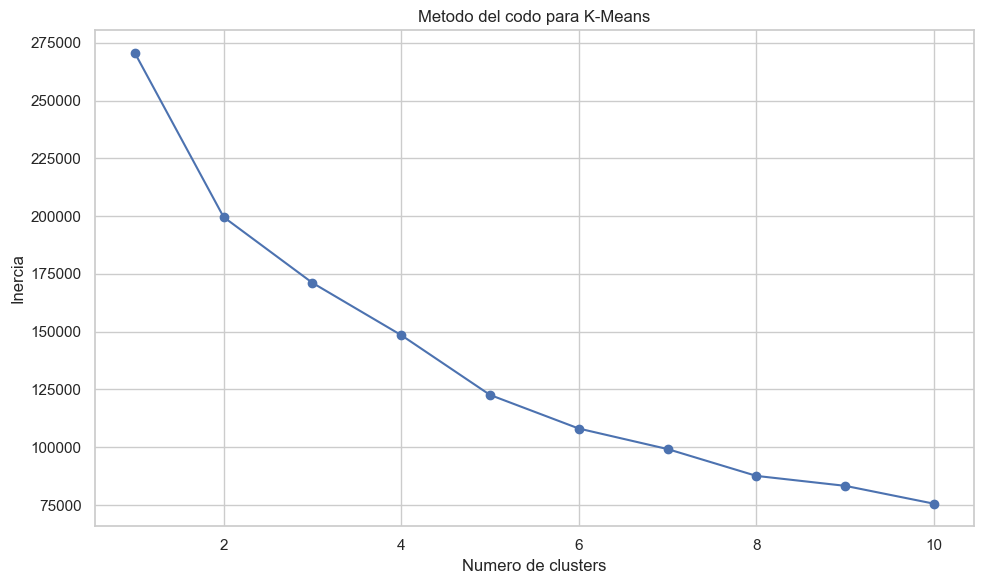

Para k=2, el silhouette score es: 0.3017
Para k=3, el silhouette score es: 0.3151
Para k=4, el silhouette score es: 0.3437
Para k=5, el silhouette score es: 0.3695
Para k=6, el silhouette score es: 0.3850


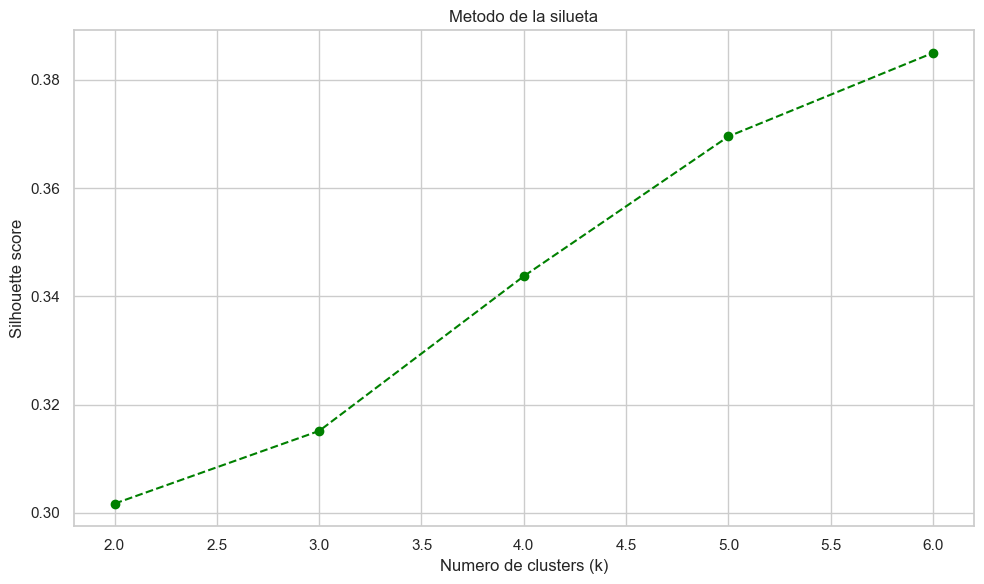

In [8]:
# Evaluamos la inercia para identificar un rango razonable de K.
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.title('Metodo del codo para K-Means')
plt.grid(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metodo_codo.png', dpi=150)
plt.show()

# Complementamos la seleccion de K usando silhouette score.
X_sample = X_scaled[:10000]
silhouette_scores = []
k_range = range(2, 7)
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f'Para k={k}, el silhouette score es: {score:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Metodo de la silueta')
plt.xlabel('Numero de clusters (k)')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metodo_silueta.png', dpi=150)
plt.show()


### Decisión final de k (KMeans)
- Regla de decisión: elegimos **k = 5** porque equilibra separación entre grupos, estabilidad de la inercia y facilidad de interpretación.
- En el codo, la reducción de inercia mantiene ganancias útiles hasta ese punto y luego muestra rendimientos decrecientes.
- En silhouette, valores mayores para `k` más altos no compensan la pérdida de simplicidad y comunicación ejecutiva.
- Tradeoff aplicado: priorizamos una segmentación suficientemente separada y estable, evitando sobre-fragmentar perfiles.
**Evidencia:** `Results/metodo_codo.png` y `Results/metodo_silueta.png`.


In [9]:
k_values_codo = list(range(1, len(inertia) + 1))
k_values_sil = list(range(2, 2 + len(silhouette_scores)))
silhouette_by_k = dict(zip(k_values_sil, silhouette_scores))

kmeans_eval = pd.DataFrame({
    'k': k_values_codo,
    'inercia': inertia,
})
kmeans_eval['delta_inercia'] = kmeans_eval['inercia'].shift(1) - kmeans_eval['inercia']
kmeans_eval['silhouette'] = kmeans_eval['k'].map(silhouette_by_k)

selected_k = 5
sil_k = silhouette_by_k.get(selected_k, np.nan)
sil_k_next = silhouette_by_k.get(selected_k + 1, np.nan)

display(kmeans_eval)

just_k = (
    f"### Justificacion explicita del K final (K-Means)\n"
    f"- Combinamos dos criterios: codo (caida de inercia) y silhouette (separacion/cohesion).\n"
    f"- Elegimos **k={selected_k}** porque mantiene buena calidad de separacion (silhouette={sil_k:.4f}) y evita sobre-fragmentar segmentos.\n"
    f"- Aunque k={selected_k + 1} mejora silhouette ({sil_k_next:.4f}), la ganancia marginal se considera menor frente a la interpretabilidad de perfiles.\n"
    f"- Decision final: **k={selected_k}** como equilibrio entre calidad estadistica y utilidad analitica."
)
display(Markdown(just_k))


,k,inercia,delta_inercia,silhouette
0,1,270600.000000,NaN,NaN
1,2,199586.682374,71013.317626,0.301686
2,3,171133.084053,28453.598321,0.315122
3,4,148511.221414,22621.862639,0.343708
4,5,122640.356637,25870.864778,0.369532
5,6,108100.652933,14539.703703,0.384969
6,7,99218.922699,8881.730234,NaN
7,8,87608.959189,11609.963510,NaN
8,9,83312.460159,4296.499030,NaN
9,10,75581.334505,7731.125653,NaN


### Justificacion explicita del K final (K-Means)
- Combinamos dos criterios: codo (caida de inercia) y silhouette (separacion/cohesion).
- Elegimos **k=5** porque mantiene buena calidad de separacion (silhouette=0.3695) y evita sobre-fragmentar segmentos.
- Aunque k=6 mejora silhouette (0.3850), la ganancia marginal se considera menor frente a la interpretabilidad de perfiles.
- Decision final: **k=5** como equilibrio entre calidad estadistica y utilidad analitica.

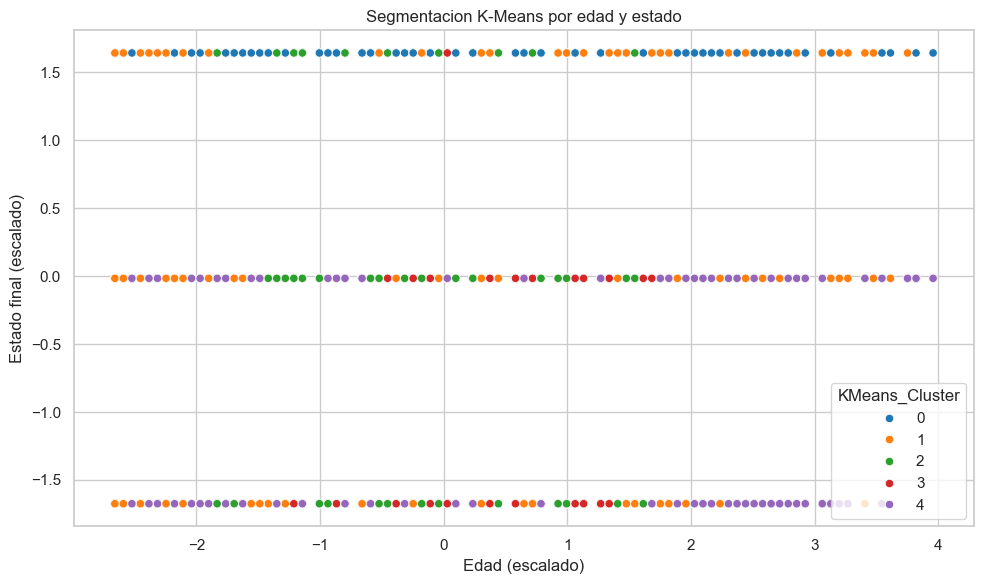

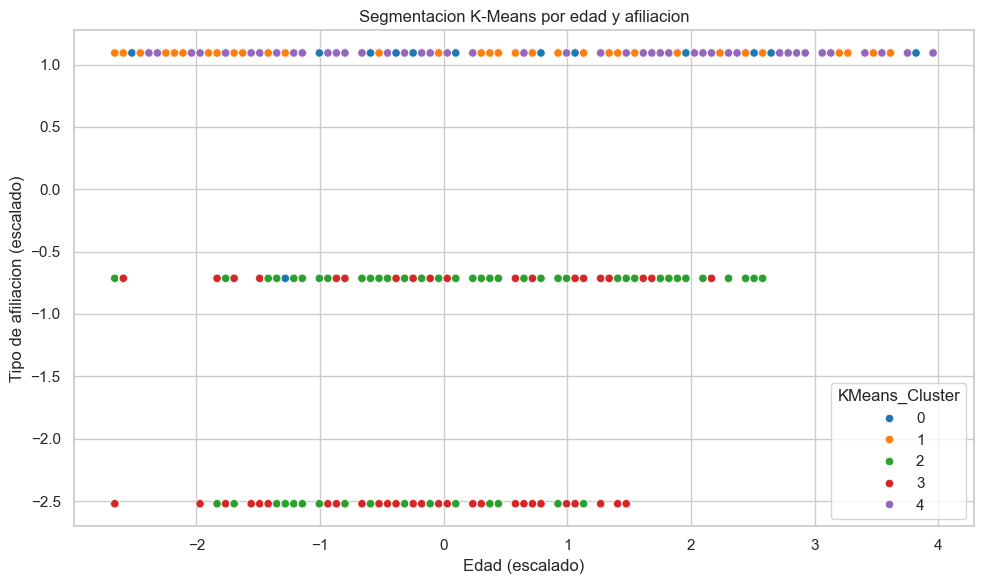

In [10]:
# Entrenamos el modelo final de K-Means con el k seleccionado.
selected_k = int(globals().get('selected_k', 5))
kmeans = KMeans(n_clusters=selected_k, n_init='auto', random_state=RANDOM_STATE)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (escalado)')
plt.ylabel('Estado final (escalado)')
plt.title('Segmentacion K-Means por edad y estado')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_kmeans_edad.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (escalado)')
plt.ylabel('Tipo de afiliacion (escalado)')
plt.title('Segmentacion K-Means por edad y afiliacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_kmeans_afiliacion.png', dpi=150)
plt.show()


In [11]:
kmeans_summary = df.groupby('KMeans_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(kmeans_summary)
kmeans_summary.to_csv(RESULTS_DIR / 'resumen_clusters_kmeans.csv')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


### Perfiles identificados
#### Perfiles KMeans
- Redactamos perfiles por cluster en formato interpretativo (2-4 líneas por segmento), no solo tabular.
- Cada perfil combina tamaño del cluster, edad promedio, afiliación dominante y estado final promedio.
- Esta lectura traduce métricas del modelo en segmentos accionables.
**Evidencia:** `Results/resumen_clusters_kmeans.csv` y la salida textual de perfiles en esta sección.


In [12]:
kmeans_counts = df['KMeans_Cluster'].value_counts().sort_index()
aff_map = {1: 'Convenio', 2: 'Silver', 3: 'Gold'}

for cluster_id in kmeans_summary.index:
    row = kmeans_summary.loc[cluster_id]
    cluster_n = int(kmeans_counts.loc[cluster_id])
    cluster_pct = 100 * cluster_n / len(df)

    genero_label = 'masculino' if row['GENERO'] >= 0.5 else 'femenino'
    afiliacion_label = aff_map.get(int(np.clip(round(row['TIPO_AFILIACION']), 1, 3)), 'Mixto')

    perfil = (
        f"**Cluster {cluster_id}**\n"
        f"- Representa **{cluster_n:,} registros** ({cluster_pct:.2f}% del total).\n"
        f"- Predomina el perfil **{genero_label}** con **edad media {row['EDAD']:.1f}** anos.\n"
        f"- La afiliacion promedio se aproxima a **{afiliacion_label}** ({row['TIPO_AFILIACION']:.2f}).\n"
        f"- El estado final promedio es **{row['ESTAFINAL']:.2f}**, util para priorizar acciones por segmento."
    )
    display(Markdown(perfil))


**Cluster 0**
- Representa **6,825 registros** (10.09% del total).
- Predomina el perfil **femenino** con **edad media 37.4** anos.
- La afiliacion promedio se aproxima a **Gold** (2.72).
- El estado final promedio es **3.00**, util para priorizar acciones por segmento.

**Cluster 1**
- Representa **10,361 registros** (15.32% del total).
- Predomina el perfil **masculino** con **edad media 36.7** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00).
- El estado final promedio es **2.05**, util para priorizar acciones por segmento.

**Cluster 2**
- Representa **23,985 registros** (35.45% del total).
- Predomina el perfil **masculino** con **edad media 38.4** anos.
- La afiliacion promedio se aproxima a **Silver** (1.97).
- El estado final promedio es **1.99**, util para priorizar acciones por segmento.

**Cluster 3**
- Representa **12,790 registros** (18.91% del total).
- Predomina el perfil **femenino** con **edad media 41.4** anos.
- La afiliacion promedio se aproxima a **Silver** (1.89).
- El estado final promedio es **1.83**, util para priorizar acciones por segmento.

**Cluster 4**
- Representa **13,689 registros** (20.24% del total).
- Predomina el perfil **femenino** con **edad media 38.4** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00).
- El estado final promedio es **1.70**, util para priorizar acciones por segmento.

## 6) DBSCAN: selección de parámetros + entrenamiento
- Ejecutamos búsqueda en grilla de `eps` y `min_samples` para evaluar sensibilidad de densidad.
- Seleccionamos parámetros por tradeoff entre silhouette sin ruido, número de clusters y proporción de outliers.
- Entrenamos DBSCAN final y caracterizamos clusters con y sin ruido.
- Contrastamos sus resultados frente a K-Means para análisis complementario.
**Evidencia:** `Results/dbscan_busqueda_parametros.csv`, `Results/resumen_clusters_dbscan.csv`, `Results/resumen_clusters_dbscan_sin_ruido.csv`.


,eps,min_samples,n_clusters,noise_ratio,silhouette
3,0.3,30,16,0.0359,0.499682
7,0.5,30,15,0.0143,0.496314
6,0.5,20,16,0.0098,0.495867
11,0.7,30,15,0.0116,0.494501
1,0.3,10,19,0.0067,0.494409
10,0.7,20,16,0.0064,0.493870
15,0.9,30,16,0.0052,0.493131
14,0.9,20,16,0.0050,0.493065
19,1.1,30,16,0.0050,0.493065
5,0.5,10,18,0.0029,0.493011


Parametros seleccionados DBSCAN -> eps=0.3, min_samples=30


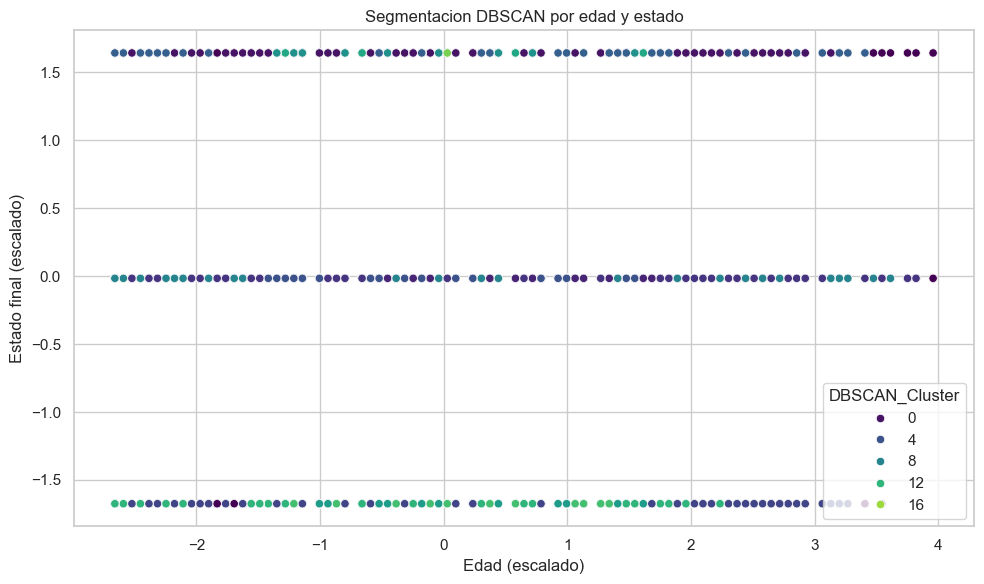

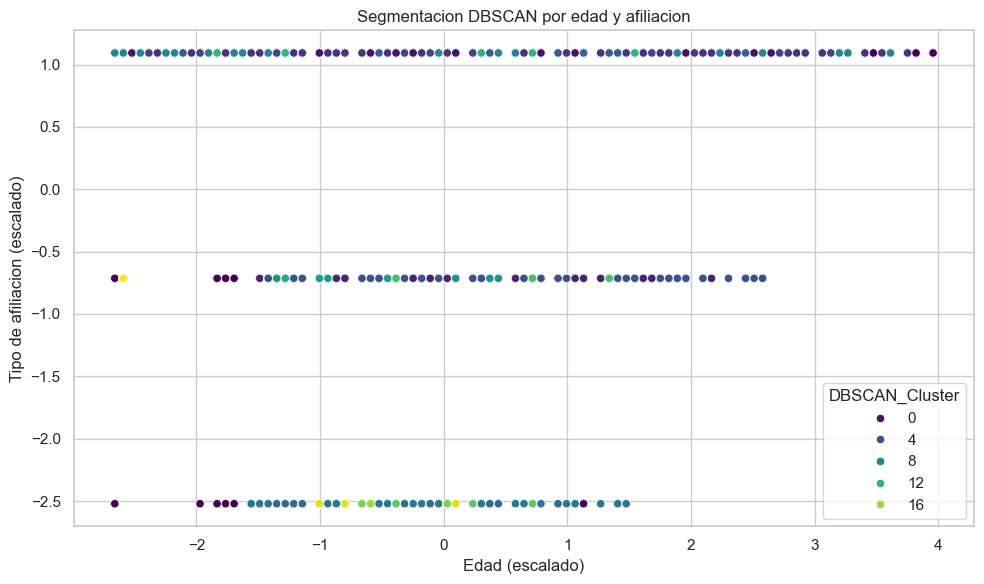

In [13]:
# Buscamos hiperparametros de DBSCAN con una grilla simple.
search_sample = X_scaled[:10000]
search_rows = []

for eps in [0.3, 0.5, 0.7, 0.9, 1.1, 1.3]:
    for min_samples in [5, 10, 20, 30]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(search_sample)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = float((labels == -1).mean())

        score = np.nan
        valid_mask = labels != -1
        if n_clusters > 1 and valid_mask.sum() > 1 and len(set(labels[valid_mask])) > 1:
            score = silhouette_score(search_sample[valid_mask], labels[valid_mask])

        search_rows.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'silhouette': score,
        })

dbscan_search = pd.DataFrame(search_rows).sort_values(
    ['silhouette', 'noise_ratio', 'n_clusters'],
    ascending=[False, True, False],
    na_position='last'
)

display(dbscan_search.head(10))
dbscan_search.to_csv(RESULTS_DIR / 'dbscan_busqueda_parametros.csv', index=False)

if dbscan_search['silhouette'].notna().any():
    best_row = dbscan_search[dbscan_search['silhouette'].notna()].iloc[0]
else:
    best_row = dbscan_search.sort_values(['n_clusters', 'noise_ratio'], ascending=[False, True]).iloc[0]

best_eps = float(best_row['eps'])
best_min_samples = int(best_row['min_samples'])
print(f'Parametros seleccionados DBSCAN -> eps={best_eps}, min_samples={best_min_samples}')

# Entrenamos DBSCAN final con los parametros seleccionados.
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.xlabel('Edad (escalado)')
plt.ylabel('Estado final (escalado)')
plt.title('Segmentacion DBSCAN por edad y estado')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_dbscan_edad.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.xlabel('Edad (escalado)')
plt.ylabel('Tipo de afiliacion (escalado)')
plt.title('Segmentacion DBSCAN por edad y afiliacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_dbscan_afiliacion.png', dpi=150)
plt.show()


### Decisión final de eps/min_samples (DBSCAN)
- Regla de decisión: elegimos **eps = 0.30** y **min_samples = 30** porque maximizan silhouette sin ruido, manteniendo ruido en rango razonable y número de clusters interpretable.
- El criterio compara simultáneamente calidad interna, granularidad de segmentación y proporción de outliers.
- En DBSCAN, el **ruido** (`-1`) representa puntos sin densidad local suficiente; no se usa en silhouette para evitar sesgo en la cohesión de clusters válidos.
- Este enfoque permite separar señal estructural de observaciones atípicas y mejora la lectura de perfiles.
**Evidencia:** `Results/dbscan_busqueda_parametros.csv` y `Results/resumen_clusters_dbscan_sin_ruido.csv`.


In [14]:
dbscan_candidates = dbscan_search.copy()
if dbscan_candidates['silhouette'].notna().any():
    dbscan_candidates = dbscan_candidates[dbscan_candidates['silhouette'].notna()].copy()

best_candidate = dbscan_candidates.iloc[0]
low_noise_candidate = dbscan_candidates.sort_values(['noise_ratio', 'silhouette'], ascending=[True, False]).iloc[0]
high_cluster_candidate = dbscan_candidates.sort_values(['n_clusters', 'silhouette'], ascending=[False, False]).iloc[0]

display(dbscan_candidates.head(10)[['eps', 'min_samples', 'silhouette', 'n_clusters', 'noise_ratio']])

just_db = (
    f"### Justificacion explicita de `eps` y `min_samples` (DBSCAN)\n"
    f"- Seleccion final: **eps={best_eps:.2f}** y **min_samples={best_min_samples}**.\n"
    f"- Esta configuracion prioriza buen compromiso entre separacion (silhouette={best_candidate['silhouette']:.4f}), cantidad de clusters ({int(best_candidate['n_clusters'])}) y ruido ({best_candidate['noise_ratio']:.2%}).\n"
    f"- Alternativa de menor ruido: eps={low_noise_candidate['eps']:.2f}, min_samples={int(low_noise_candidate['min_samples'])} (ruido={low_noise_candidate['noise_ratio']:.2%}).\n"
    f"- Alternativa con mayor fragmentacion: eps={high_cluster_candidate['eps']:.2f}, min_samples={int(high_cluster_candidate['min_samples'])} (clusters={int(high_cluster_candidate['n_clusters'])})."
)
display(Markdown(just_db))


,eps,min_samples,silhouette,n_clusters,noise_ratio
3,0.3,30,0.499682,16,0.0359
7,0.5,30,0.496314,15,0.0143
6,0.5,20,0.495867,16,0.0098
11,0.7,30,0.494501,15,0.0116
1,0.3,10,0.494409,19,0.0067
10,0.7,20,0.493870,16,0.0064
15,0.9,30,0.493131,16,0.0052
14,0.9,20,0.493065,16,0.0050
19,1.1,30,0.493065,16,0.0050
5,0.5,10,0.493011,18,0.0029


### Justificacion explicita de `eps` y `min_samples` (DBSCAN)
- Seleccion final: **eps=0.30** y **min_samples=30**.
- Esta configuracion prioriza buen compromiso entre separacion (silhouette=0.4997), cantidad de clusters (16) y ruido (3.59%).
- Alternativa de menor ruido: eps=1.30, min_samples=5 (ruido=0.01%).
- Alternativa con mayor fragmentacion: eps=0.50, min_samples=5 (clusters=20).

In [15]:
display(df['DBSCAN_Cluster'].value_counts().sort_index())

dbscan_summary = df.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(dbscan_summary)
dbscan_summary.to_csv(RESULTS_DIR / 'resumen_clusters_dbscan.csv')


DBSCAN_Cluster
-1       121
 0      4931
 1      9187
 2      9566
 3      4119
 4     16971
 5      2523
 6       544
 7       915
 8      5777
 9      2888
 10     3260
 11     1884
 12     2023
 13     2138
 14      247
 15      233
 16      154
 17       31
 18       99
 19       39
Name: count, dtype: int64

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
-1,0.628,35.545,1.909,1.504
0,0.000,36.207,3.000,3.000
1,0.000,42.680,2.000,2.000
2,0.000,38.447,2.000,3.000
3,0.000,38.124,1.000,3.000
4,1.000,39.224,2.000,2.000
5,1.000,35.579,3.000,3.000
6,1.000,32.114,2.000,1.000
7,0.000,34.375,2.000,1.000


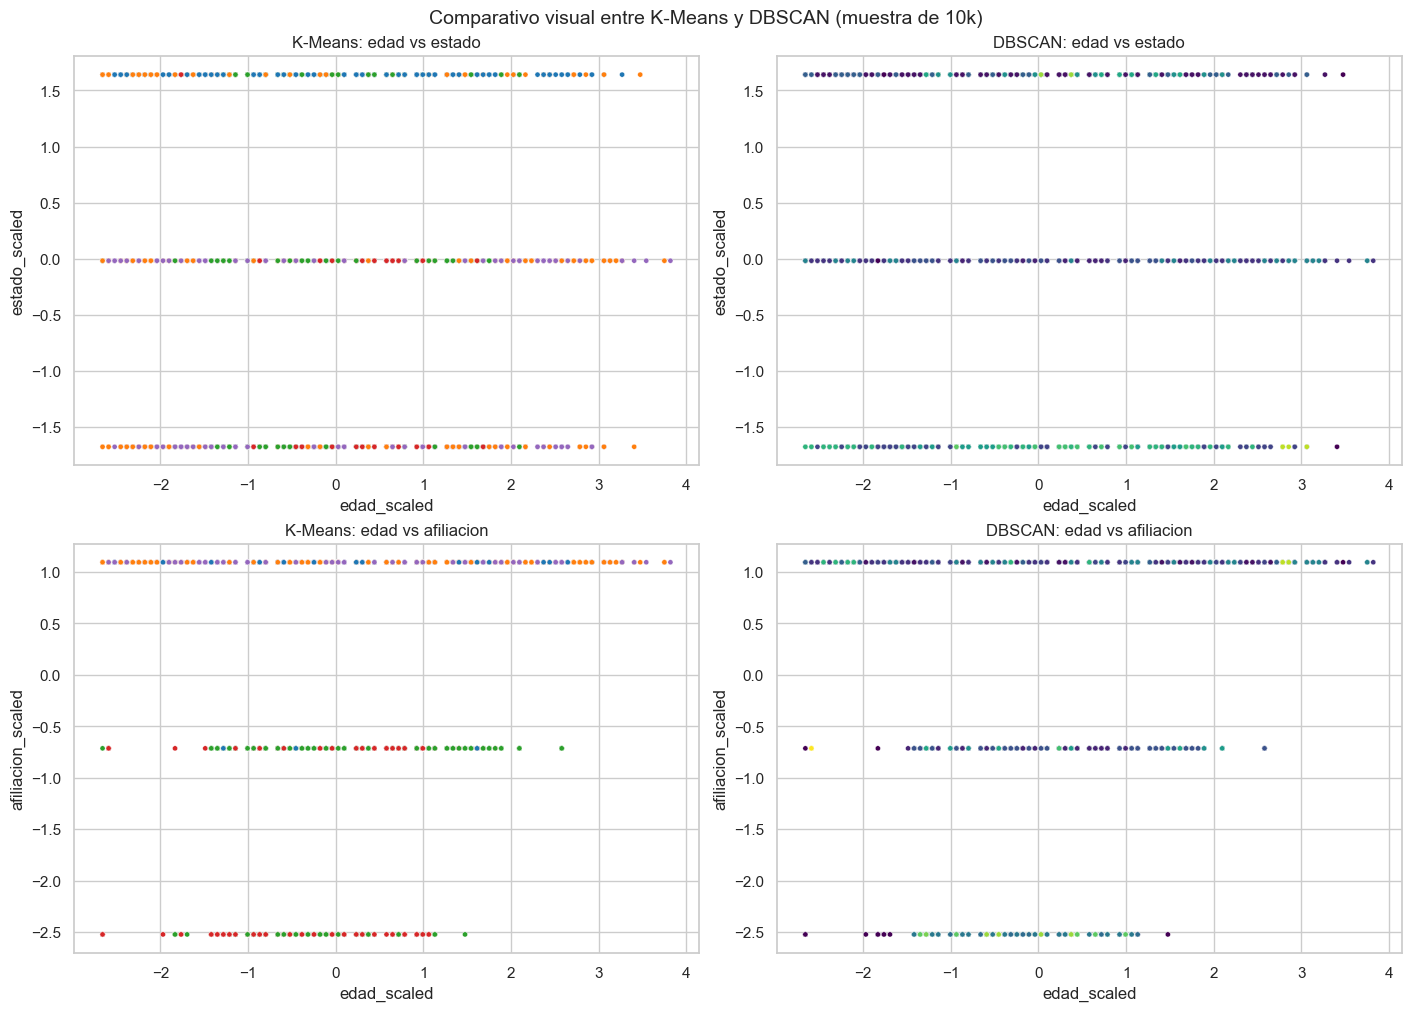

In [16]:
plot_size = min(len(X_scaled), 10000)
plot_idx = np.random.default_rng(RANDOM_STATE).choice(len(X_scaled), size=plot_size, replace=False)

comp_df = pd.DataFrame({
    'edad_scaled': X_scaled[plot_idx, 1],
    'estado_scaled': X_scaled[plot_idx, 2],
    'afiliacion_scaled': X_scaled[plot_idx, 3],
    'kmeans': df['KMeans_Cluster'].to_numpy()[plot_idx],
    'dbscan': df['DBSCAN_Cluster'].to_numpy()[plot_idx],
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

sns.scatterplot(data=comp_df, x='edad_scaled', y='estado_scaled', hue='kmeans', palette='tab10', s=14, ax=axes[0, 0], legend=False)
axes[0, 0].set_title('K-Means: edad vs estado')

sns.scatterplot(data=comp_df, x='edad_scaled', y='estado_scaled', hue='dbscan', palette='viridis', s=14, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('DBSCAN: edad vs estado')

sns.scatterplot(data=comp_df, x='edad_scaled', y='afiliacion_scaled', hue='kmeans', palette='tab10', s=14, ax=axes[1, 0], legend=False)
axes[1, 0].set_title('K-Means: edad vs afiliacion')

sns.scatterplot(data=comp_df, x='edad_scaled', y='afiliacion_scaled', hue='dbscan', palette='viridis', s=14, ax=axes[1, 1], legend=False)
axes[1, 1].set_title('DBSCAN: edad vs afiliacion')

fig.suptitle('Comparativo visual entre K-Means y DBSCAN (muestra de 10k)', fontsize=14)
plt.savefig(RESULTS_DIR / 'comparativo_kmeans_dbscan.png', dpi=150)
plt.show()


In [17]:
df_no_noise = df[df['DBSCAN_Cluster'] != -1]

dbscan_no_noise_summary = df_no_noise.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(dbscan_no_noise_summary)
dbscan_no_noise_summary.to_csv(RESULTS_DIR / 'resumen_clusters_dbscan_sin_ruido.csv')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
0,0.0,36.207,3.0,3.0
1,0.0,42.680,2.0,2.0
2,0.0,38.447,2.0,3.0
3,0.0,38.124,1.0,3.0
4,1.0,39.224,2.0,2.0
5,1.0,35.579,3.0,3.0
6,1.0,32.114,2.0,1.0
7,0.0,34.375,2.0,1.0
8,1.0,37.783,2.0,3.0


#### Perfiles DBSCAN
- Redactamos perfiles por cluster denso (sin ruido) para describir microsegmentos de comportamiento.
- Incorporamos una interpretación específica para el ruido (`-1`) como observaciones atípicas/outliers.
- La narrativa prioriza interpretabilidad operativa sobre simple reporte de medias.
**Evidencia:** `Results/resumen_clusters_dbscan_sin_ruido.csv`, `Results/resumen_clusters_dbscan.csv` y salida textual de perfiles en esta sección.


In [18]:
dbscan_counts = df['DBSCAN_Cluster'].value_counts().sort_index()
aff_map = {1: 'Convenio', 2: 'Silver', 3: 'Gold'}

for cluster_id in dbscan_summary.index:
    row = dbscan_summary.loc[cluster_id]
    cluster_n = int(dbscan_counts.loc[cluster_id])
    cluster_pct = 100 * cluster_n / len(df)

    if cluster_id == -1:
        perfil = (
            f"**Cluster -1 (Ruido)**\n"
            f"- Representa **{cluster_n:,} registros** ({cluster_pct:.2f}% del total).\n"
            f"- Corresponde a observaciones atipicas que no cumplen criterios de densidad local.\n"
            f"- Este bloque debe revisarse para control de calidad de datos y deteccion de casos especiales."
        )
    else:
        genero_label = 'masculino' if row['GENERO'] >= 0.5 else 'femenino'
        afiliacion_label = aff_map.get(int(np.clip(round(row['TIPO_AFILIACION']), 1, 3)), 'Mixto')
        perfil = (
            f"**Cluster {int(cluster_id)}**\n"
            f"- Representa **{cluster_n:,} registros** ({cluster_pct:.2f}% del total).\n"
            f"- Predomina el perfil **{genero_label}** con **edad media {row['EDAD']:.1f}** anos.\n"
            f"- La afiliacion promedio se aproxima a **{afiliacion_label}** ({row['TIPO_AFILIACION']:.2f}) y el estado final es **{row['ESTAFINAL']:.2f}**."
        )
    display(Markdown(perfil))


**Cluster -1 (Ruido)**
- Representa **121 registros** (0.18% del total).
- Corresponde a observaciones atipicas que no cumplen criterios de densidad local.
- Este bloque debe revisarse para control de calidad de datos y deteccion de casos especiales.

**Cluster 0**
- Representa **4,931 registros** (7.29% del total).
- Predomina el perfil **femenino** con **edad media 36.2** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **3.00**.

**Cluster 1**
- Representa **9,187 registros** (13.58% del total).
- Predomina el perfil **femenino** con **edad media 42.7** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **2.00**.

**Cluster 2**
- Representa **9,566 registros** (14.14% del total).
- Predomina el perfil **femenino** con **edad media 38.4** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **2.00**.

**Cluster 3**
- Representa **4,119 registros** (6.09% del total).
- Predomina el perfil **femenino** con **edad media 38.1** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **1.00**.

**Cluster 4**
- Representa **16,971 registros** (25.09% del total).
- Predomina el perfil **masculino** con **edad media 39.2** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **2.00**.

**Cluster 5**
- Representa **2,523 registros** (3.73% del total).
- Predomina el perfil **masculino** con **edad media 35.6** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **3.00**.

**Cluster 6**
- Representa **544 registros** (0.80% del total).
- Predomina el perfil **masculino** con **edad media 32.1** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **2.00**.

**Cluster 7**
- Representa **915 registros** (1.35% del total).
- Predomina el perfil **femenino** con **edad media 34.4** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **2.00**.

**Cluster 8**
- Representa **5,777 registros** (8.54% del total).
- Predomina el perfil **masculino** con **edad media 37.8** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **2.00**.

**Cluster 9**
- Representa **2,888 registros** (4.27% del total).
- Predomina el perfil **masculino** con **edad media 36.0** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **3.00**.

**Cluster 10**
- Representa **3,260 registros** (4.82% del total).
- Predomina el perfil **masculino** con **edad media 37.6** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **1.00**.

**Cluster 11**
- Representa **1,884 registros** (2.78% del total).
- Predomina el perfil **femenino** con **edad media 40.5** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **3.00**.

**Cluster 12**
- Representa **2,023 registros** (2.99% del total).
- Predomina el perfil **masculino** con **edad media 33.9** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **1.00**.

**Cluster 13**
- Representa **2,138 registros** (3.16% del total).
- Predomina el perfil **femenino** con **edad media 41.6** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **1.00**.

**Cluster 14**
- Representa **247 registros** (0.37% del total).
- Predomina el perfil **femenino** con **edad media 35.4** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **1.00**.

**Cluster 15**
- Representa **233 registros** (0.34% del total).
- Predomina el perfil **femenino** con **edad media 33.7** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **3.00**.

**Cluster 16**
- Representa **154 registros** (0.23% del total).
- Predomina el perfil **masculino** con **edad media 30.7** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **3.00**.

**Cluster 17**
- Representa **31 registros** (0.05% del total).
- Predomina el perfil **masculino** con **edad media 82.5** anos.
- La afiliacion promedio se aproxima a **Gold** (3.00) y el estado final es **1.00**.

**Cluster 18**
- Representa **99 registros** (0.15% del total).
- Predomina el perfil **masculino** con **edad media 28.6** anos.
- La afiliacion promedio se aproxima a **Convenio** (1.00) y el estado final es **1.00**.

**Cluster 19**
- Representa **39 registros** (0.06% del total).
- Predomina el perfil **femenino** con **edad media 1.0** anos.
- La afiliacion promedio se aproxima a **Silver** (2.00) y el estado final es **2.00**.

## 7) Reducción dimensional: PCA y t-SNE
- Aplicamos PCA para visualizar separación global en un plano lineal interpretable.
- Aplicamos t-SNE para capturar estructura local no lineal y vecindades complejas.
- Contrastamos ambas proyecciones para validar consistencia de la segmentación.
- Usamos estas vistas como evidencia de estructura latente no aleatoria.
**Evidencia:** `Results/pca_kmeans.png`, `Results/tsne_kmeans.png`, `Results/tsne_genero.png`.


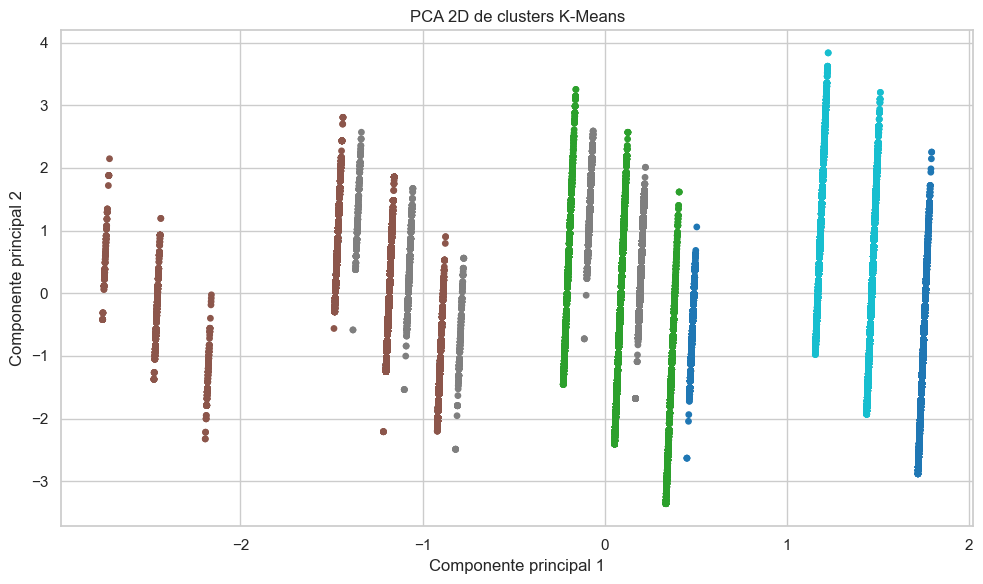

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10', s=15)
plt.title('PCA 2D de clusters K-Means')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_kmeans.png', dpi=150)
plt.show()


In [20]:
display(kmeans_summary)


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


In [21]:
for cluster_id in sorted(df['KMeans_Cluster'].unique()):
    print()
    print(f'Cluster {cluster_id}')
    display(df[df['KMeans_Cluster'] == cluster_id][['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].head())



Cluster 0


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
0,0,40,3,3
4,0,36,3,3
5,0,39,3,3
10,0,8,3,3
18,0,31,3,3



Cluster 1


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
13,1,37,3,3
17,1,55,2,3
26,1,45,2,3
73,1,30,2,3
81,1,60,3,3



Cluster 2


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
9,1,50,2,2
12,1,27,2,2
14,1,45,2,1
20,1,29,2,2
22,1,25,3,2



Cluster 3


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
1,0,49,2,2
8,0,31,2,2
15,0,45,2,1
19,0,48,2,2
21,0,50,2,2



Cluster 4


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
2,0,40,2,3
3,0,49,1,3
6,0,55,1,3
7,0,32,2,3
11,0,45,1,3


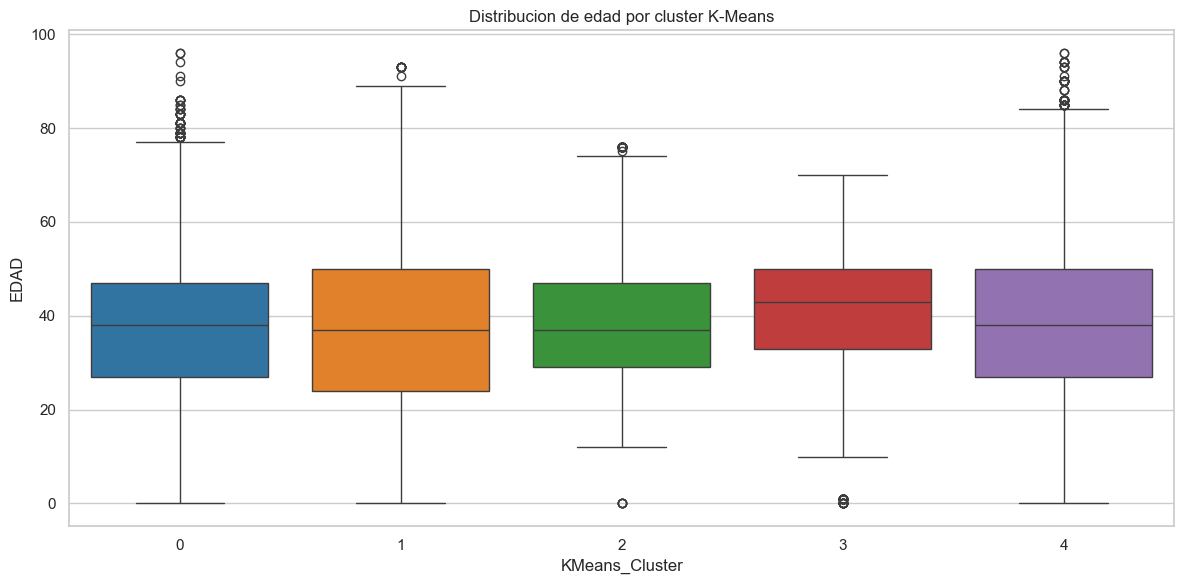

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='KMeans_Cluster',
    y='EDAD',
    hue='KMeans_Cluster',
    data=df,
    palette='tab10',
    legend=False
)
plt.title('Distribucion de edad por cluster K-Means')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tiempo_uso_cluster.png', dpi=150)
plt.show()


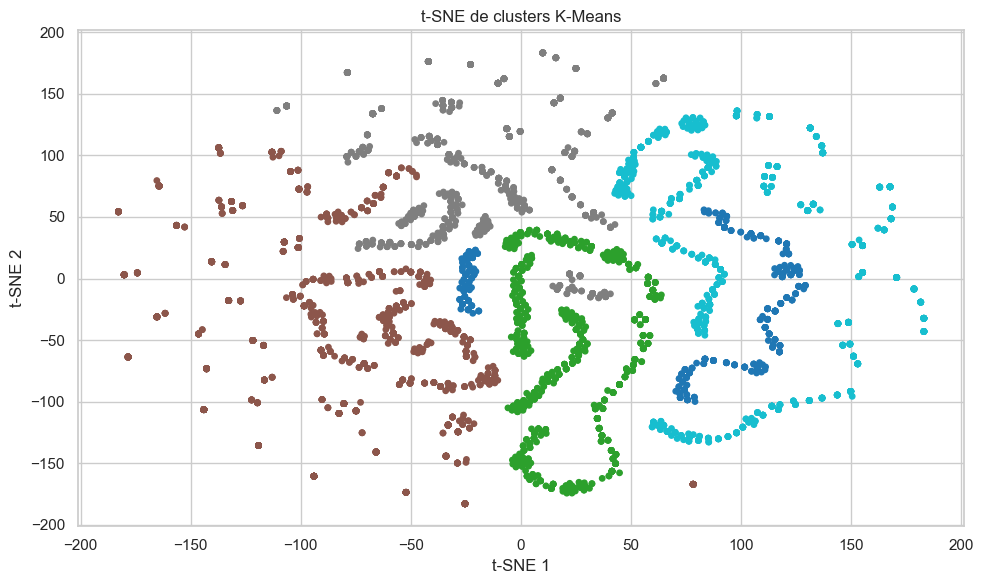

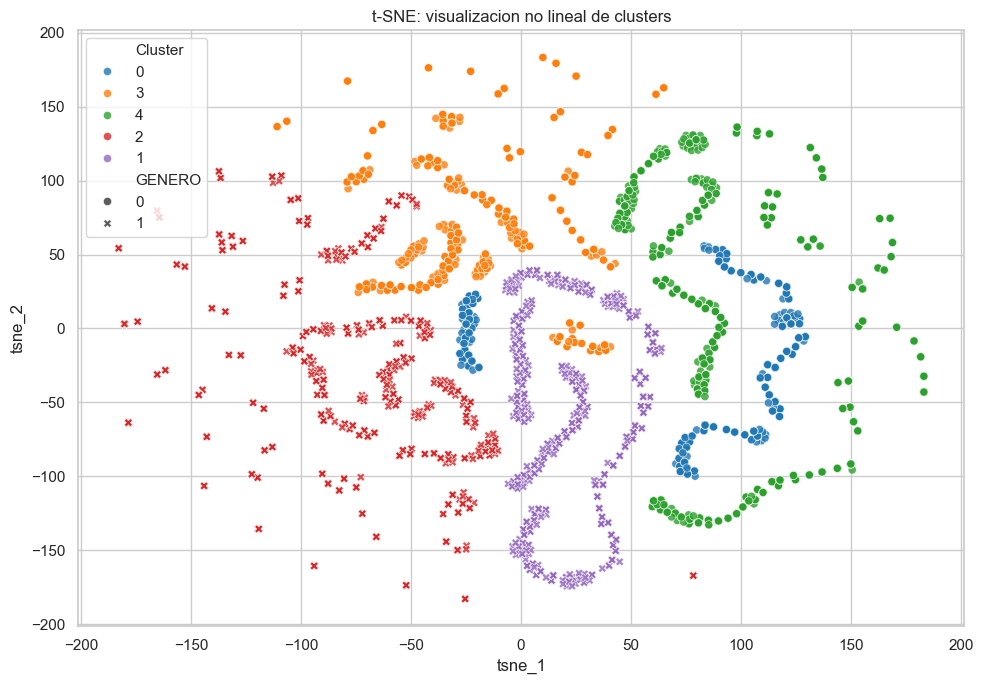

In [23]:
# Limitamos la muestra para que t-SNE sea ejecutable en hardware comun.
sample_size = min(len(X_scaled), 5000)
X_tsne_input = X_scaled[:sample_size]
labels_tsne = df['KMeans_Cluster'].iloc[:sample_size].to_numpy()
gender_tsne = df['GENERO'].iloc[:sample_size].to_numpy()

tsne = TSNE(
    n_components=2,
    method='barnes_hut',
    perplexity=30,
    learning_rate=200,
    random_state=RANDOM_STATE,
    init='pca'
)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, cmap='tab10', s=15)
plt.title('t-SNE de clusters K-Means')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_kmeans.png', dpi=150)
plt.show()

df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['Cluster'] = labels_tsne.astype(str)
df_tsne['GENERO'] = gender_tsne

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2',
    hue='Cluster',
    style='GENERO',
    palette='tab10',
    alpha=0.8,
    s=35
)
plt.title('t-SNE: visualizacion no lineal de clusters')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_genero.png', dpi=150)
plt.show()


In [24]:
comparison_size = min(len(X_scaled), 10000)
comparison_idx = np.random.default_rng(RANDOM_STATE).choice(len(X_scaled), size=comparison_size, replace=False)

X_cmp = X_scaled[comparison_idx]
kmeans_cmp_labels = df['KMeans_Cluster'].to_numpy()[comparison_idx]
dbscan_cmp_labels = df['DBSCAN_Cluster'].to_numpy()[comparison_idx]

kmeans_cmp_silhouette = silhouette_score(X_cmp, kmeans_cmp_labels) if len(set(kmeans_cmp_labels)) > 1 else np.nan

dbscan_valid = dbscan_cmp_labels != -1
if dbscan_valid.sum() > 1 and len(set(dbscan_cmp_labels[dbscan_valid])) > 1:
    dbscan_cmp_silhouette = silhouette_score(X_cmp[dbscan_valid], dbscan_cmp_labels[dbscan_valid])
else:
    dbscan_cmp_silhouette = np.nan

comparison_metrics = pd.DataFrame([
    {
        'modelo': 'KMeans',
        'n_clusters': int(df['KMeans_Cluster'].nunique()),
        'ruido_pct': 0.0,
        'silhouette': kmeans_cmp_silhouette,
    },
    {
        'modelo': 'DBSCAN',
        'n_clusters': int(df.loc[df['DBSCAN_Cluster'] != -1, 'DBSCAN_Cluster'].nunique()),
        'ruido_pct': float((df['DBSCAN_Cluster'] == -1).mean()),
        'silhouette': dbscan_cmp_silhouette,
    },
])

display(comparison_metrics)


,modelo,n_clusters,ruido_pct,silhouette
0,KMeans,5,0.000000,0.367526
1,DBSCAN,20,0.001789,0.470058


## 8) Conclusiones y comparación de modelos
- Comparamos K-Means y DBSCAN para decidir cuál usar según objetivo analítico.
- Confirmamos que ambos modelos capturan estructura útil, pero con compromisos distintos de estabilidad e interpretación.
- Integramos resultados numéricos y visuales para sostener decisiones defendibles.
- Cerramos con limitaciones y plan de mejora incremental.

### Análisis crítico
- **Supuestos:** K-Means asume clusters compactos alrededor de centroides; DBSCAN agrupa por densidad local.
- **Sensibilidad a parámetros:** K-Means depende de `k`; DBSCAN depende fuertemente de `eps` y `min_samples`.
- **Manejo de outliers:** K-Means fuerza asignación; DBSCAN separa ruido (`-1`) y permite análisis específico de atípicos.

### Limitaciones actuales
- Se modeló con un conjunto reducido de variables (`GENERO`, `EDAD`, `ESTAFINAL`, `TIPO_AFILIACION`), sin ingeniería temporal de `FECHA_CITA`.
- La codificación actual simplifica variables categóricas y puede ocultar relaciones más finas.
- La estabilidad entre muestras puede variar y requiere validación adicional por remuestreo.

### Propuestas de mejora (3-6)
- Agrupar `ESPECIALIDAD` en macro-categorías para reducir dispersión semántica y ruido.
- Probar `RobustScaler` y comparar estabilidad de clusters frente a outliers.
- Añadir validación de estabilidad por bootstrap/submuestreo con métricas de consistencia.
- Incluir métricas complementarias (Calinski-Harabasz, Davies-Bouldin) en la decisión final.

### Propuestas de uso (2-4)
- Usar perfiles KMeans para segmentación operativa y diseño de campañas estables por tipo de afiliación/edad.
- Usar perfiles DBSCAN para detectar microgrupos y casos atípicos que requieran intervención diferenciada.
- Priorizar acciones de retención o seguimiento clínico según estado final promedio por segmento.

**Evidencia:** `Results/comparativo_kmeans_dbscan.png`, `Results/resumen_clusters_kmeans.csv`, `Results/resumen_clusters_dbscan_sin_ruido.csv`.


In [25]:
display(kmeans_summary)

print('Clusters unicos KMeans:', sorted(df['KMeans_Cluster'].unique()))
print('Clusters unicos DBSCAN:', sorted(df['DBSCAN_Cluster'].unique()))
print(f'Parametros finales DBSCAN: eps={best_eps}, min_samples={best_min_samples}')
print(f'Porcentaje de ruido DBSCAN: {(df["DBSCAN_Cluster"] == -1).mean():.2%}')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


Clusters unicos KMeans: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
Clusters unicos DBSCAN: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
Parametros finales DBSCAN: eps=0.3, min_samples=30
Porcentaje de ruido DBSCAN: 0.18%
